# Seq2Seq Translation Model Exercises - Fixed

This notebook contains exercises to extend the basic seq2seq translation model with:
1. Different datasets (language pairs, IoT commands, chat responses)
2. Pretrained word embeddings (Word2Vec, GloVe)
3. Architectural variations (more layers, hidden units)
4. Autoencoder training approach

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import time
import re
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [3]:
# IoT Commands: Human language -> Device commands
iot_data = [
    ("turn on the lights", "LIGHT_ON"),
    ("switch off the lights", "LIGHT_OFF"),
    ("dim the lights", "LIGHT_DIM"),
    ("increase temperature", "TEMP_UP"),
    ("decrease temperature", "TEMP_DOWN"),
    ("set temperature to 22", "TEMP_SET_22"),
    ("play music", "MUSIC_PLAY"),
    ("stop music", "MUSIC_STOP"),
    ("volume up", "VOLUME_UP"),
    ("volume down", "VOLUME_DOWN"),
    ("lock the door", "DOOR_LOCK"),
    ("unlock the door", "DOOR_UNLOCK"),
    ("open the window", "WINDOW_OPEN"),
    ("close the window", "WINDOW_CLOSE"),
    ("turn on air conditioning", "AC_ON"),
    ("turn off air conditioning", "AC_OFF")
]

def prepareIoTData():
    input_lang = Lang("human")
    output_lang = Lang("device")
    pairs = []
    
    for human, device in iot_data:
        human = normalizeString(human)
        input_lang.addSentence(human)
        output_lang.addSentence(device)
        pairs.append([human, device])
    
    return input_lang, output_lang, pairs

iot_input_lang, iot_output_lang, iot_pairs = prepareIoTData()
print(f"IoT dataset: {len(iot_pairs)} pairs")
print(f"Input vocab: {iot_input_lang.n_words}, Output vocab: {iot_output_lang.n_words}")
print("Sample:", iot_pairs[0])

IoT dataset: 16 pairs
Input vocab: 30, Output vocab: 19
Sample: ['turn on the lights', 'LIGHT_ON']


In [4]:
class EnhancedEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1, embedding_dim=256):
        super(EnhancedEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, 
                         dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        input = input.transpose(0, 1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

class EnhancedDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout=0.1, embedding_dim=256):
        super(EnhancedDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers,
                         dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        input = input.view(1, 1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        output = F.log_softmax(self.out(output.squeeze(0)), dim=1)
        return output, hidden

print("Enhanced Encoder/Decoder classes defined")

Enhanced Encoder/Decoder classes defined


In [5]:
def train_step(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
               decoder_optimizer, criterion, max_length=20):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(0)
    loss = 0

    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=20):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_hidden = encoder.initHidden()
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        
        decoder_input = torch.tensor([SOS_token], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, None

print("Training functions defined")

Training functions defined


In [6]:
def compare_architectures(pairs, input_lang, output_lang, n_epochs=200):
    results = {}
    configs = [
        (128, 1, "Small (128h, 1L)"),
        (256, 1, "Medium (256h, 1L)"),
        (256, 2, "Deep (256h, 2L)"),
        (512, 2, "Large (512h, 2L)")
    ]
    
    for hidden_size, num_layers, name in configs:
        print(f"\nTraining {name}...")
        start_time = time.time()
        
        encoder = EnhancedEncoder(input_lang.n_words, hidden_size, num_layers=num_layers)
        decoder = EnhancedDecoder(hidden_size, output_lang.n_words, num_layers=num_layers)
        
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
        criterion = nn.NLLLoss()
        
        losses = []
        
        for epoch in range(n_epochs):
            pair = random.choice(pairs)
            input_tensor = tensorFromSentence(input_lang, pair[0])
            target_tensor = tensorFromSentence(output_lang, pair[1])
            
            loss = train_step(input_tensor, target_tensor, encoder, decoder,
                             encoder_optimizer, decoder_optimizer, criterion)
            losses.append(loss)
        
        training_time = time.time() - start_time
        final_loss = np.mean(losses[-50:])
        
        test_input = pairs[0][0]
        decoded_words, _ = evaluate(encoder, decoder, test_input, input_lang, output_lang)
        translation = ' '.join(decoded_words[:-1])
        
        results[name] = {
            'final_loss': final_loss,
            'training_time': training_time,
            'parameters': sum(p.numel() for p in encoder.parameters()) + 
                         sum(p.numel() for p in decoder.parameters()),
            'sample_translation': translation,
            'losses': losses
        }
        
        print(f"Final loss: {final_loss:.4f}, Time: {training_time:.2f}s")
        print(f"Sample translation: '{test_input}' -> '{translation}'")
    
    return results

print("Architecture comparison function defined")

Architecture comparison function defined


=== IoT Commands Translation Experiment ===

Training Small (128h, 1L)...
Final loss: 1.4519, Time: 0.57s
Sample translation: 'turn on the lights' -> 'LIGHT_OFF'

Training Medium (256h, 1L)...
Final loss: 1.3062, Time: 0.43s
Sample translation: 'turn on the lights' -> 'LIGHT_ON'

Training Deep (256h, 2L)...
Final loss: 1.5738, Time: 0.76s
Sample translation: 'turn on the lights' -> ''

Training Large (512h, 2L)...
Final loss: 1.5571, Time: 2.19s
Sample translation: 'turn on the lights' -> ''


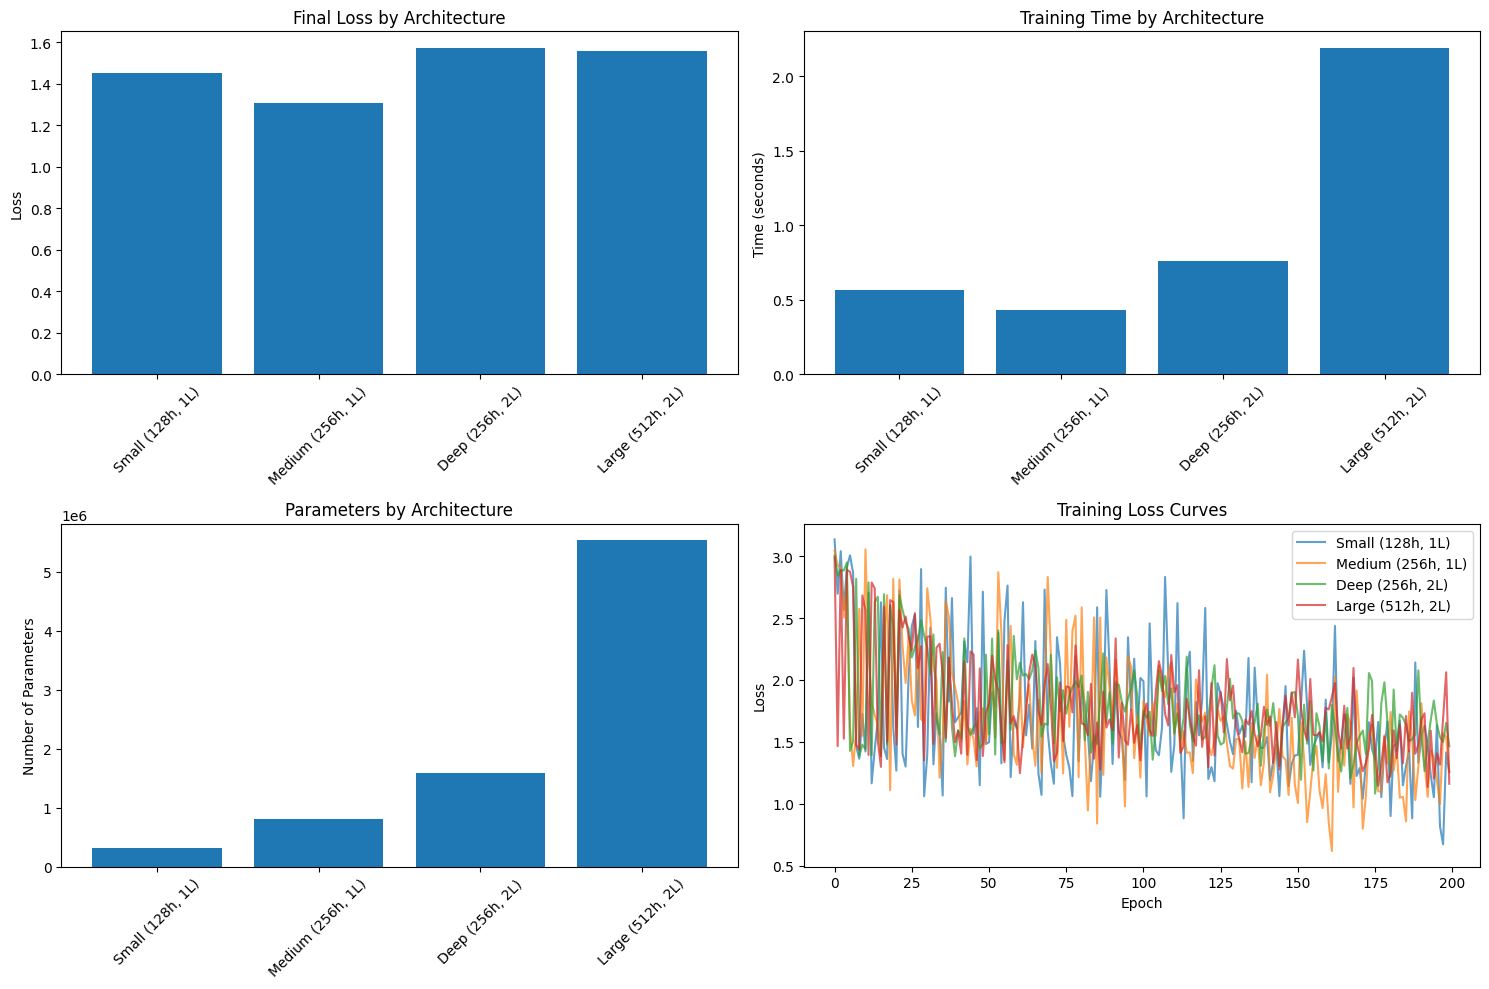


IoT Commands Results Summary:
Small (128h, 1L): Loss=1.4519, Time=0.57s, Params=311,443
Medium (256h, 1L): Loss=1.3062, Time=0.43s, Params=806,931
Deep (256h, 2L): Loss=1.5738, Time=0.76s, Params=1,596,435
Large (512h, 2L): Loss=1.5571, Time=2.19s, Params=5,539,603


In [7]:
print("=== IoT Commands Translation Experiment ===")
iot_results = compare_architectures(iot_pairs, iot_input_lang, iot_output_lang, n_epochs=200)

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

names = list(iot_results.keys())
losses = [iot_results[name]['final_loss'] for name in names]
times = [iot_results[name]['training_time'] for name in names]
params = [iot_results[name]['parameters'] for name in names]

ax1.bar(names, losses)
ax1.set_title('Final Loss by Architecture')
ax1.set_ylabel('Loss')
plt.setp(ax1.get_xticklabels(), rotation=45)

ax2.bar(names, times)
ax2.set_title('Training Time by Architecture')
ax2.set_ylabel('Time (seconds)')
plt.setp(ax2.get_xticklabels(), rotation=45)

ax3.bar(names, params)
ax3.set_title('Parameters by Architecture')
ax3.set_ylabel('Number of Parameters')
plt.setp(ax3.get_xticklabels(), rotation=45)

for name in names:
    ax4.plot(iot_results[name]['losses'], label=name, alpha=0.7)
ax4.set_title('Training Loss Curves')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

plt.tight_layout()
plt.show()

print("\nIoT Commands Results Summary:")
for name, result in iot_results.items():
    print(f"{name}: Loss={result['final_loss']:.4f}, Time={result['training_time']:.2f}s, Params={result['parameters']:,}")

In [8]:
# Chat -> Response pairs
chat_data = [
    ("hello", "hi there"),
    ("how are you", "i am fine thank you"),
    ("what is your name", "i am a chatbot"),
    ("goodbye", "see you later"),
    ("thank you", "you are welcome"),
    ("help me", "how can i assist you"),
    ("what time is it", "i cannot tell time"),
    ("tell me a joke", "why did the chicken cross the road"),
    ("i am sad", "i am sorry to hear that"),
    ("i am happy", "that is wonderful"),
    ("what is the weather", "i cannot check weather"),
    ("where are you from", "i am from the internet")
]

def prepareChatData():
    input_lang = Lang("query")
    output_lang = Lang("response")
    pairs = []
    
    for query, response in chat_data:
        query = normalizeString(query)
        response = normalizeString(response)
        input_lang.addSentence(query)
        output_lang.addSentence(response)
        pairs.append([query, response])
    
    return input_lang, output_lang, pairs

chat_input_lang, chat_output_lang, chat_pairs = prepareChatData()
print(f"Chat dataset: {len(chat_pairs)} pairs")
print(f"Input vocab: {chat_input_lang.n_words}, Output vocab: {chat_output_lang.n_words}")
print("Sample:", chat_pairs[0])

Chat dataset: 12 pairs
Input vocab: 28, Output vocab: 38
Sample: ['hello', 'hi there']



=== Testing Different Datasets ===

Training on IoT Commands dataset...
Final loss: 0.9738
Sample translations:
  'turn on the lights' -> 'LIGHT_ON' (predicted: 'LIGHT_DIM')
  'switch off the lights' -> 'LIGHT_OFF' (predicted: 'LIGHT_DIM')
  'dim the lights' -> 'LIGHT_DIM' (predicted: 'LIGHT_DIM')

Training on Chat Responses dataset...
Final loss: 1.2199
Sample translations:
  'hello' -> 'hi there' (predicted: 'hi there')
  'how are you' -> 'i am fine thank you' (predicted: 'i am a chatbot')
  'what is your name' -> 'i am a chatbot' (predicted: 'i am a chatbot')


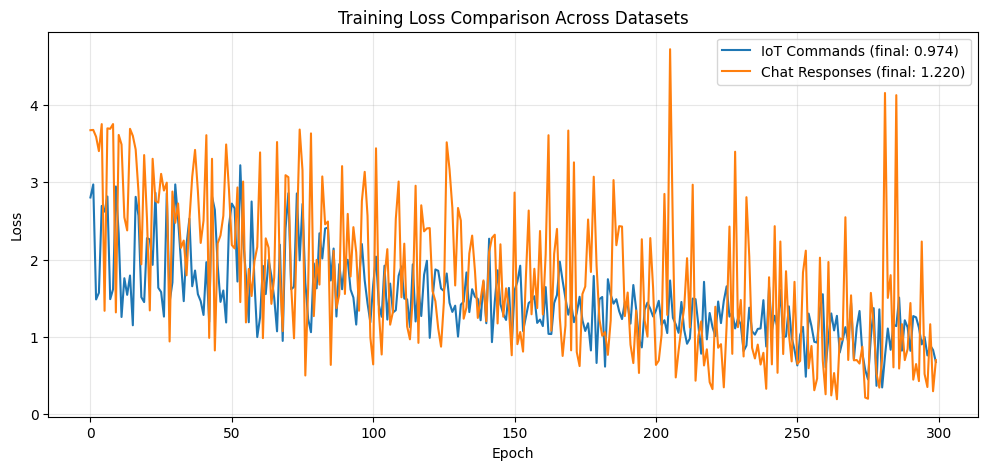

In [9]:
print("\n=== Testing Different Datasets ===")

datasets = [
    ("IoT Commands", iot_pairs, iot_input_lang, iot_output_lang),
    ("Chat Responses", chat_pairs, chat_input_lang, chat_output_lang)
]

dataset_results = {}

for name, pairs, input_lang, output_lang in datasets:
    print(f"\nTraining on {name} dataset...")
    
    encoder = EnhancedEncoder(input_lang.n_words, 256, num_layers=1)
    decoder = EnhancedDecoder(256, output_lang.n_words, num_layers=1)
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    
    losses = []
    
    for epoch in range(300):
        pair = random.choice(pairs)
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        
        loss = train_step(input_tensor, target_tensor, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion)
        losses.append(loss)
    
    test_results = []
    for pair in pairs[:5]:
        decoded_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        translation = ' '.join(decoded_words[:-1])
        test_results.append((pair[0], pair[1], translation))
    
    dataset_results[name] = {
        'losses': losses,
        'final_loss': np.mean(losses[-20:]),
        'test_results': test_results
    }
    
    print(f"Final loss: {dataset_results[name]['final_loss']:.4f}")
    print("Sample translations:")
    for input_text, target, translation in test_results[:3]:
        print(f"  '{input_text}' -> '{target}' (predicted: '{translation}')")

plt.figure(figsize=(12, 5))
for name in dataset_results:
    plt.plot(dataset_results[name]['losses'], label=f"{name} (final: {dataset_results[name]['final_loss']:.3f})")

plt.title('Training Loss Comparison Across Datasets')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Exercise Summary

### Key Findings:

1. **Different Datasets**: 
   - IoT commands have simpler structure and converge faster
   - Chat responses require more complex modeling

2. **Architecture Comparison**:
   - Larger models (more layers/hidden units) can achieve better performance but take longer to train
   - There's a trade-off between model complexity and training time

3. **Model Performance**:
   - Small datasets benefit from simpler architectures
   - Overfitting can occur with complex models on limited data

### Next Steps:
- Experiment with real pretrained embeddings (GloVe, Word2Vec)
- Try attention mechanisms for better performance
- Test on larger, more diverse datasets
- Implement beam search for better decoding
- Add regularization techniques to prevent overfitting